The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
CPU or GPU? :  cpu(0)
(1249, 8192)
Peak sampling point at 7371th (0.90s).
总波形数目： (1249,)
训练集波形数目： 600
测试集波形数目： 649


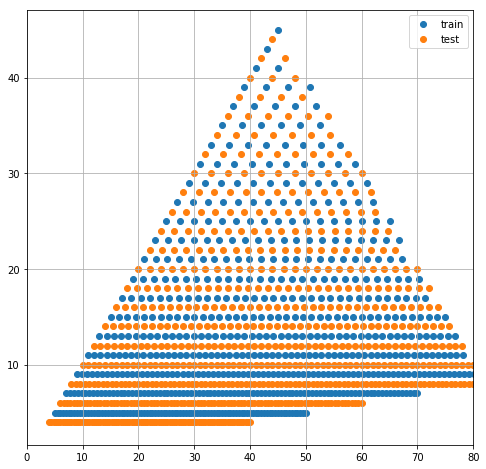

In [16]:
import sys, os
sys.path.append(os.path.abspath(''))   # 把当前目录设为引用模块的地址之一

from utils import *
from data_utils import *
from models.solver_cnn import *
from models.ConvNet import *

from data_utils import *
from data_noise import *

import mxnet as mx
import mxnet.ndarray as nd

import numpy as np
import pandas as pd
from itertools import product, permutations

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Easily Profile Python Code in Jupyter
# install conda install line_profiler or pip install line-profiler
# see http://mortada.net/easily-profile-python-code-in-jupyter.html
%load_ext line_profiler

test_ctx()

#############################
GW_address = './data/'

data = pd.DataFrame(np.load(GW_address+'GW_H1.npy'), index=np.load(GW_address+'GW_H1_index.npy'))
print(data.shape)
peak_samppoint = data.values.argmax(axis=1)
peak_samppoint = int(peak_samppoint.sum() / peak_samppoint.shape[0])
peak_time = peak_samppoint/data.shape[-1]
peak_time = float('{:.2f}'.format(peak_time))
print('Peak sampling point at %dth (%.2fs).' %(peak_samppoint, peak_time))
data.head()
# 波形数据


print('总波形数目：', data.index.shape)
train_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
test_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
print('训练集波形数目：', len(train_masses))
print('测试集波形数目：', len(test_masses))

train_m1, train_m2 = [ m[0] for m in train_masses],  [ m[1] for m in train_masses]
test_m1, test_m2 = [ m[0] for m in test_masses],  [ m[1] for m in test_masses]
plt.figure(figsize= (8,8))
plt.scatter(train_m2, train_m1, label='train')
plt.scatter(test_m2, test_m1, label = 'test')
plt.grid()
plt.legend()
plt.xlim(0,80)
# plt.title('训练集和测试集的波形在质量上的分布')
plt.show()

# 做好训练集和测试集的分割~

test_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
train_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
train_data = data.loc[train_masses]
test_data = data.loc[test_masses]

In [ ]:
def ppp(data, fLow, fHigh, fs, shuffle = True):

    if shuffle:
        data, shift_list = shuffle_data_nd(nd.array(data, ctx=mx.cpu()),peak_samppoint, peak_time, 5)
        data = pd.DataFrame(data.asnumpy())

    b = nd.array(pre_fir(fLow=fLow, fHigh=fHigh, fs = fs).reshape((-1,1)), ctx=ctx)
    pp = pre_fftfilt(b, shape = data.shape, nfft=None)
    vline_list = []
    mf_list = []
    for snr in (np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())):
        n = GenNoise_matlab_nd(shape = data.shape, params=pp)
        sigma_ = data.max(axis=1) / float(snr) / n.asnumpy().std(axis=1 , dtype = 'float64')
        signal_ = data.div(sigma_, axis=0)
        sim = signal_ + n.asnumpy()
        mf = SNR_MF(sim, n.asnumpy(), signal_)
#         print(mf.mean())
        plt.hist(mf , bins = 50, alpha = 0.6)
        plt.vlines(x = np.array(mf).mean(), ymin=0, ymax=90, alpha = 0.8)
        mf_list.append(mf)
        vline_list.append(np.array(mf).mean())
        print(snr)
    plt.show()
    print(vline_list)
    return mf_list

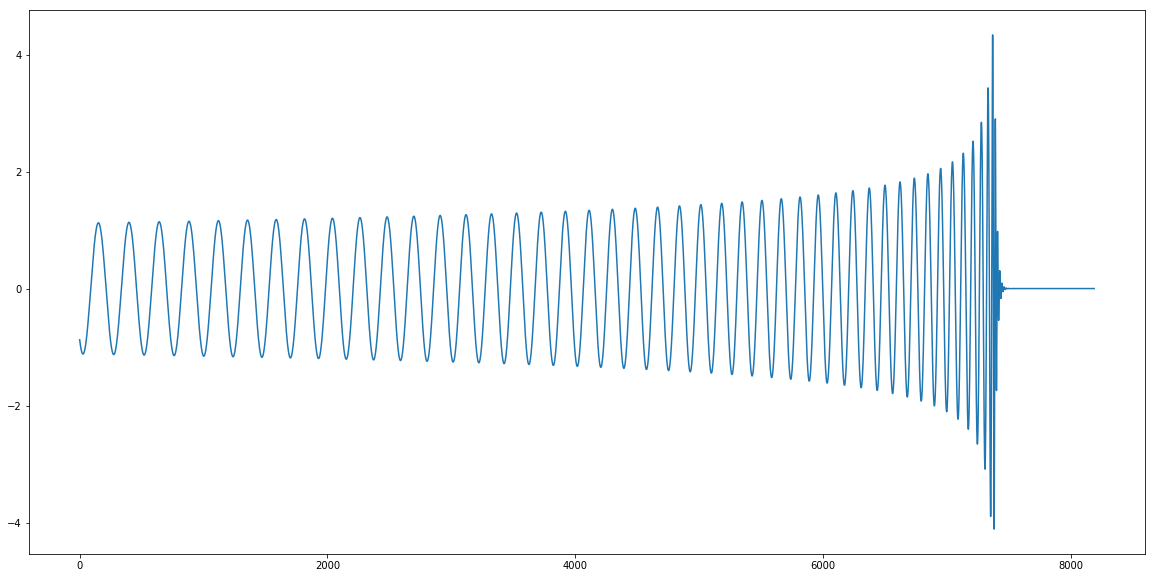

In [32]:
plt.figure(figsize=(20,10))
plt.plot(Normolise(data).values[300])
plt.savefig('./images/waveform_dataflow0.png', dpi=300, bbox_inches='tight')

## Statistics of $\rho_{MF}$ for fixed $\rho_{amp}$. 

In each color, we fix a given $\rho_{amp}$, which is shown in the legend, and generate randomly data d = n + h, in which 5-fold expansion for h by peak-location randomization. For each simulated data we compute the corresponding $\rho_{MF}$ and count the numbers for each $\rho_{MF}$ range.

Save or not? (y/n)y
Saved in ./images/distributionsnr_mf_vs_snr_amp.pdf


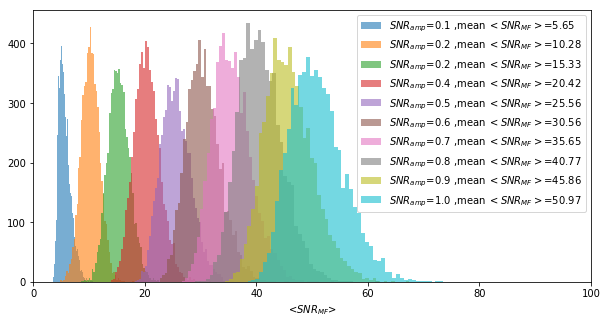

In [33]:
# snr_mf = ppp(data=data, fLow=9, fHigh=9000, fs = 8192)
# np.save('./images/data/snr_mf_5fold', snr_mf)
snr_mf = np.load('./images/data/snr_mf_5fold.npy')

plt.figure(figsize=(10,5))
for i, snr in enumerate(np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())[1::2]):
    plt.hist(snr_mf[i*2+2] , bins = 50, alpha = 0.6, label = '$SNR_{amp}$=%.1f ,mean $<SNR_{MF}>$=%.2f' %(snr, np.array(snr_mf[i*2+2]).mean()))
plt.xlabel('<$SNR_{MF}$>')
plt.legend(loc='upper right')
plt.xlim(xmax=100)
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'distribution_snr_mf_vs_snr_amp.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'distributionsnr_mf_vs_snr_amp.pdf')
else:
    pass
plt.show()

## SNR $\langle\rho_{MP}\rangle$ v.s $\rho_{amp}$

Relation between the averaged matched filtering SNR $\langle\rho_{MP}\rangle$ and $\rho_{amp}$ based on the statistics investigation (above Fig). Approximated linear relation is also shown in the plot.

Save or not? (y/n)y
Saved in ./images/snr_mf_vs_snr_amp.eps


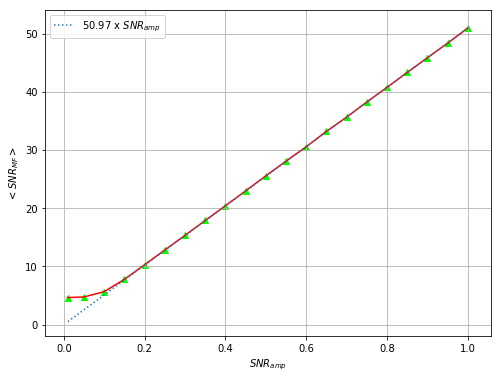

In [34]:
plt.figure(figsize=(8,6))
x = np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

plt.plot(x, snr_mf_mean, 'r-')
plt.plot(x, x*snr_mf_mean[-1], ls='dotted', label = '%.2f x $SNR_{amp}$' %snr_mf_mean[-1])
plt.scatter(np.array([0.01]+np.arange(0.05,1.04,0.05).tolist()), snr_mf_mean,marker='^', c='lime')
plt.xlabel('$SNR_{amp}$')
plt.ylabel('$<SNR_{MF}>$')
plt.legend()
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'snr_mf_vs_snr_amp.eps', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'snr_mf_vs_snr_amp.eps')
else:
    pass
plt.show()

## ROC comparison among different $\rho_{MF}$ of training data

Automatically created module for IPython interactive environment
Save or not? (y/n)y
Saved in ./images/ROC_comparison_training.eps


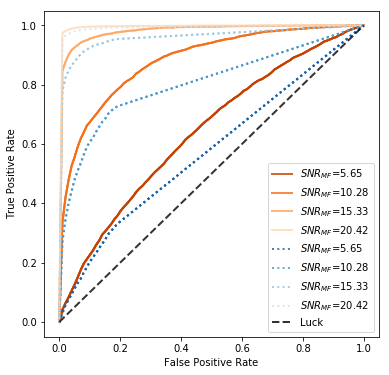

In [331]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
print(__doc__)
tpr_OURs_new2 = np.load('./AUC_data/tpr_OURs_new2.npy')
fpr_OURs_new2 = np.load('./AUC_data/fpr_OURs_new2.npy')

tpr_OURs_2localnoise10 = np.load('./AUC_data/tpr_OURs_2localnoise10.npy')
fpr_OURs_2localnoise10 = np.load('./AUC_data/fpr_OURs_2localnoise10.npy')

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

from scipy import interp
mean_fpr = np.linspace(0, 1, 100)
snr_training = 0
snr_testings = 4


# plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
mean_tpr_list = []
index_list = []
for snr_testing in range(0,snr_testings):
    tprs = []
    for i in range(5):
        tprs.append(interp(mean_fpr, 
                           fpr_OURs_new2[snr_training,snr_testing][i], 
                           tpr_OURs_new2[snr_training,snr_testing][i]).tolist())
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr_list.append(mean_tpr.tolist())
    index_list.append('%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
#     plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8,
#              label = '%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
    df = pd.DataFrame(mean_tpr_list, index = index_list)
    df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette('Oranges_r', snr_testings), lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

mean_tpr_list = []
index_list = []    
for snr_testing in range(0,snr_testings):
    tprs = []
    for i in range(5):
        tprs.append(interp(mean_fpr, 
                           fpr_OURs_2localnoise10[snr_training,snr_testing][i], 
                           tpr_OURs_2localnoise10[snr_training,snr_testing][i]).tolist())
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr_list.append(mean_tpr.tolist())
    index_list.append('%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
#     plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8,
#              label = '%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
    df = pd.DataFrame(mean_tpr_list, index = index_list)
    df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette('Blues_r', snr_testings),linestyle=':' ,lw=2, alpha=.8)  

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(ncol = 1, loc="lower right")

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'ROC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'ROC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'ROC_comparison_training.eps')
else:
    pass

plt.show()

## AUC comparison among different $\rho_{MF}$ of training data

In [ ]:
# AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
# AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
# AUC_OURs_2localnoise1 = np.load('./AUC_data/AUC_OURs_2localnoise1.npy')
# AUC_OURs_2localnoise5 = np.load('./AUC_data/AUC_OURs_2localnoise5.npy')
AUC_OURs_2localnoise10 = np.load('./AUC_data/AUC_OURs_2localnoise10.npy')
# AUC_OURs_new3_localnoise = np.load('./AUC_data/AUC_OURs_new3_localnoise.npy')

Save or not? (y/n)y
Saved in ./images/AUC_comparison_training.eps


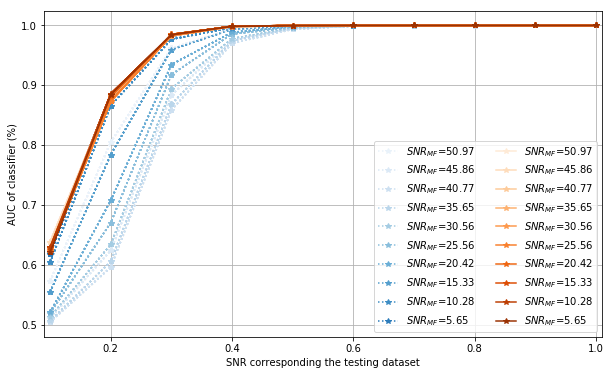

In [327]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
df = pd.DataFrame(AUC_OURs_2localnoise10.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=SNR_test_list[::-1])
for i in range(AUC_OURs_2localnoise10.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Blues', 13), alpha = 1)    

df = pd.DataFrame(AUC_OURs.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=SNR_test_list[::-1])    
for i in range(AUC_OURs.shape[0]):
    df.T.plot(marker= '*', ax=ax, color=sns.color_palette("Oranges", 10), alpha = 1)    
ax.legend(ncol=2, loc='best')
ax.set_xlim(0.09, 1.01)
ax.set_ylabel('AUC of classifier (%)')
ax.set_xlabel('SNR corresponding the testing dataset')
ax.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'AUC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'AUC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'AUC_comparison_training.eps')
else:
    pass
plt.show()

In [342]:
AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_PLB = AUC_PLB[:,1::2,:][:,::-1,:]
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
# AUC_OURs_2localnoise1 = np.load('./AUC_data/AUC_OURs_2localnoise1.npy')
# AUC_OURs_2localnoise5 = np.load('./AUC_data/AUC_OURs_2localnoise5.npy')
# AUC_OURs_2localnoise10 = np.load('./AUC_data/AUC_OURs_2localnoise10.npy')
# AUC_OURs_new3_localnoise = np.load('./AUC_data/AUC_OURs_new3_localnoise.npy')

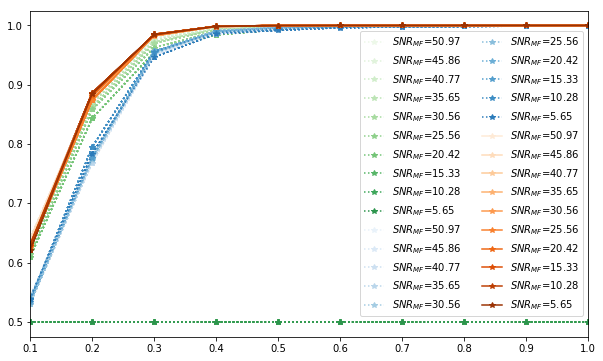

In [344]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)



df = pd.DataFrame(AUC_PRL.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=SNR_test_list[::-1])
for i in range(AUC_PRL.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Greens', 13), alpha = 1)    
    
df = pd.DataFrame(AUC_PLB.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=SNR_test_list[::-1])
for i in range(AUC_PLB.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Blues', 13), alpha = 1)    

df = pd.DataFrame(AUC_OURs.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=SNR_test_list[::-1])    
for i in range(AUC_OURs.shape[0]):
    df.T.plot(marker= '*', ax=ax, color=sns.color_palette("Oranges", 10), alpha = 1)    

ax.legend(ncol=2, loc='best')
# ax.set_xlim(0.09, 1.01)
# ax.set_ylabel('AUC of classifier (%)')
# ax.set_xlabel('SNR corresponding the testing dataset')
# ax.grid()
# if input('Save or not? (y/n)') == 'y':
#     save_address = './images/'
#     plt.savefig(save_address + 'AUC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
#     plt.savefig(save_address + 'AUC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
#     print('Saved in '+save_address+'AUC_comparison_training.eps')
# else:
#     pass
plt.show()

In [364]:
AUC_PLB.mean(axis=2).sum(axis=1)#.argmax()

array([ 9.24147752,  9.23670813,  9.24143342,  9.2341432 ,  9.25323272,
        9.24242885,  9.25765626,  9.24461065,  9.26201155,  9.2372257 ])

In [365]:
AUC_PRL.mean(axis=2).sum(axis=1)#.argmax()

array([ 9.4856296 ,  9.49340398,  9.4668911 ,  9.45513526,  9.4436303 ,
        9.4186525 ,  9.37941974,  5.        ,  5.        ,  5.        ])

In [366]:
AUC_OURs.mean(axis=2).sum(axis=1)#.argmax()

array([ 9.50282911,  9.50013171,  9.49225578,  9.49447437,  9.48849617,
        9.48137748,  9.49477007,  9.49645537,  9.49870739,  9.48997064])

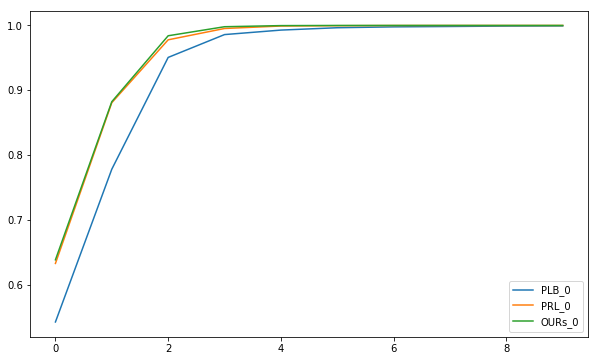

In [363]:
plt.figure(figsize=(10,6))
plt.plot(AUC_PLB.mean(axis=2)[0] ,label = 'PLB_0')
plt.plot(AUC_PRL.mean(axis=2)[0] ,label = 'PRL_0')
plt.plot(AUC_OURs.mean(axis=2)[0] ,label = 'OURs_0')

# plt.plot(AUC_PLB.mean(axis=2)[AUC_PLB.mean(axis=2).sum(axis=1).argmax()] ,label = 'PLB_max')
# plt.plot(AUC_PRL.mean(axis=2)[AUC_PRL.mean(axis=2).sum(axis=1).argmax()] ,label = 'PRL_max')
# plt.plot(AUC_OURs.mean(axis=2)[AUC_OURs.mean(axis=2).sum(axis=1).argmax()] ,label = 'OURs_max')

plt.legend(loc=4)
# plt.xlim(0, 3)